In [73]:
# ComplEx embeddings :

hidden_channels = 10
batch_size = 4096
epochs = 3000
file_path = "/home/elliot/Desktop/StageM2/data/iric/little_iric.tsv"

# Losses tests :

n_negative_triplets_per_positive = 4 # Number of false negatives triples per positive triple in the dataset for losses tests.
url = "https://purl.obolibrary.org/obo/go/go-basic.json.gz" # Where should I look for GO ?


# Imports, install and mount

In [74]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# import sys
# my_local_drive='/content/gdrive/MyDrive/SL2024/datas'
# # Ajout du path pour les librairies, fonctions et données
# sys.path.append(my_local_drive)
# # Se positionner sur le répertoire associé
# %cd $my_local_drive
# %pwd
# print("DRIVE MOUNTED")

In [75]:
! pip install cuda
! pip install torch_geometric
! pip install dgl
! pip install nxontology

import torch
import torch.optim as optim
import os.path as osp
from torch_geometric.datasets import FB15k_237
from torch_geometric.nn import ComplEx
from torch_geometric.data import Data
import pandas as pd
from tqdm import tqdm
from torch_geometric.loader import DataLoader
import dgl
import os
from torch.nn.functional import normalize

from nxontology.imports import from_file


Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement cuda (from versions: none)
ERROR: No matching distribution found for cuda
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [76]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu' # Tip : Use cpu for debugging
print(device)

cuda


# Preparing ComplEx embeddings

## TSV to pyg.Data

We want :
- x (tensorised and processed node attributes) (1 for now)
- edge_index (a tensor of shape (num_edges, 2) indicates the source node index and the destination node index)
- edge_attr (a tensor that indicate the type of each edge)
- y (edge labels - optional, can be defined as node labels if needed)

## Reading and mapping graph

What we want : Create a Data object with all the properties I want to use later

	- x (tensorised and processed node attributes) (Not for now)
	- edge_index (a tensor of shape (num_edges, 2) indicates the source node index and the destination node index)
	- y (desired edge labels - optional, can be defined as node labels if needed) (Not for now)
	- any other things you want to use later

In [77]:
iric = pd.read_csv(file_path, delimiter='\t')
display(iric)

# Mapping entities to ids

entity_set = set(iric['object']).union(set(iric['subject']))
entity_to_mapping = {entity: i for i, entity in enumerate(entity_set)}
relation_set = set(iric['predicate'])
relation_to_mapping = {relation: i for i, relation in enumerate(relation_set)}

mapped_iric = iric.copy()
mapped_iric['object'] = mapped_iric['object'].apply(lambda x: entity_to_mapping[x])
mapped_iric['subject'] = mapped_iric['subject'].apply(lambda x: entity_to_mapping[x])
mapped_iric['predicate'] = mapped_iric['predicate'].apply(lambda x: relation_to_mapping[x])

display(mapped_iric)


print("Minima in mappings :")
print('subject :', min(mapped_iric['subject']))
print('predicate :',min(mapped_iric['predicate']))
print('object :',min(mapped_iric['object']))

print(entity_to_mapping)
print(relation_to_mapping)

mapping_to_entity = {v: k for k, v in entity_to_mapping.items()}
mapping_to_relation = {v: k for k, v in relation_to_mapping.items()}
print(mapping_to_entity)
print(mapping_to_relation)

,subject,predicate,object
0,GO:0000001,is_a,GO:0048311
1,GO:0000001,is_a,GO:0048308
2,GO:0000002,is_a,GO:0007005
3,GO:0000003,is_a,GO:0008150
4,GO:0000006,is_a,GO:0005385
...,...,...,...
9994,GO:0009920,is_a,GO:0000919
9995,GO:0009920,is_a,GO:1903047
9996,GO:0009921,is_a,GO:0098797
9997,GO:0009922,is_a,GO:0016747


,subject,predicate,object
0,1653,0,7050
1,1653,0,7591
2,908,0,1245
3,3722,0,2126
4,7968,0,3568
...,...,...,...
9994,2253,0,8214
9995,2253,0,5731
9996,3992,0,875
9997,5797,0,3437


Minima in mappings :
subject : 1
predicate : 0
object : 0
{'GO:0031966': 0, 'GO:0006631': 1, 'GO:0002635': 2, 'GO:0031571': 3, 'GO:0016567': 4, 'GO:0008920': 5, 'GO:0006212': 6, 'GO:0008842': 7, 'GO:0006029': 8, 'GO:0009385': 9, 'GO:0008031': 10, 'GO:0002716': 11, 'GO:0005340': 12, 'GO:0001673': 13, 'GO:0005948': 14, 'GO:0006214': 15, 'GO:0046394': 16, 'GO:0000350': 17, 'GO:0006593': 18, 'GO:0009125': 19, 'GO:0002174': 20, 'GO:0004968': 21, 'GO:0071763': 22, 'GO:0005230': 23, 'GO:0003878': 24, 'GO:0050789': 25, 'GO:0046527': 26, 'GO:0009079': 27, 'GO:0002324': 28, 'GO:0000137': 29, 'GO:0008177': 30, 'GO:0009630': 31, 'GO:0052742': 32, 'GO:0071669': 33, 'GO:0009233': 34, 'GO:0002238': 35, 'GO:1903532': 36, 'GO:0009154': 37, 'GO:0005595': 38, 'GO:0000279': 39, 'GO:0005366': 40, 'GO:0042098': 41, 'GO:0005521': 42, 'GO:0042430': 43, 'GO:0006369': 44, 'GO:0043178': 45, 'GO:0006751': 46, 'GO:0009690': 47, 'GO:0007053': 48, 'GO:0004300': 49, 'GO:0008818': 50, 'GO:0000312': 51, 'GO:0046063': 5

## Building init vars for Data :

In [78]:
# # Initial nodes states :
# x = torch.ones(len(entity_set), 1)  # Chaque nœud a 1 pour état initial
# print('X : \n',x)

# Edges index
heads = list(mapped_iric['subject'])
tails = list(mapped_iric['object'])
edge_index = torch.tensor([heads,tails], dtype=torch.long)
print('\nEDGE INDEX : \n',edge_index)

# edges states
edge_attributes = torch.tensor(mapped_iric['predicate'])
print('\nEDGES ATTRIBUTES : \n',edge_attributes)

iric_pyg = Data(
                # x = x,
                num_nodes = len(entity_set),
                edge_index = edge_index,
                edge_attr = edge_attributes)
print('\nDATASET :\n',iric_pyg)


print("\nDataset looks valid ? \n",iric_pyg.validate(raise_on_error=True))


EDGE INDEX : 
 tensor([[1653, 1653,  908,  ..., 3992, 5797, 3133],
        [7050, 7591, 1245,  ...,  875, 3437, 4001]])

EDGES ATTRIBUTES : 
 tensor([0, 0, 0,  ..., 0, 0, 0])

DATASET :
 Data(edge_index=[2, 9999], edge_attr=[9999], num_nodes=8859)

Dataset looks valid ? 
 True


## Setting up datas and model


## Splitting dataset

In [79]:
from torch_geometric.transforms import RandomLinkSplit

transform = RandomLinkSplit(
                            num_val = 0.1,
                            num_test = 0.1,
                            is_undirected=False,
                            add_negative_train_samples=False,
                            )

train_data, val_data, test_data = transform(iric_pyg)

print(f"Hole Dataset :\n {iric_pyg}\n\nTrain:\n{train_data}\n\nTest :\n{test_data}\n\nValidation :\n{val_data}")
# Il ne faut pas regarder num_edges parce que RLS cache les arêtes mais ne les sort pas du graph.
# print(f"Number of edges in datasets : \n  Hole Dataset : {iric_pyg.num_edges}\n\n  Train: {train_data.num_edges}\n\n  Test : {test_data.num_edges}\n\n  Validation : {val_data.num_edges}")
print(f"Number of edges in datasets : \n  Train: {list(train_data.edge_label.size())[0]}\n\n  Test : {list(test_data.edge_label.size())[0]}\n\n  Validation : {list(val_data.edge_label.size())[0]}")

train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

print('\n\n',train_data.num_nodes)
print(train_data.num_edge_types)
print(train_data.__dict__)
print(train_data.edge_index[0].size())
print(train_data.edge_index[1].size())
print(train_data.edge_attr.size())
print(train_data.edge_attr)
print(train_data.num_nodes)
print(train_data.edge_index.size()[1])

Hole Dataset :
 Data(edge_index=[2, 9999], edge_attr=[9999], num_nodes=8859)

Train:
Data(edge_index=[2, 8001], edge_attr=[8001], num_nodes=8859, edge_label=[8001], edge_label_index=[2, 8001])

Test :
Data(edge_index=[2, 9000], edge_attr=[9000], num_nodes=8859, edge_label=[1998], edge_label_index=[2, 1998])

Validation :
Data(edge_index=[2, 8001], edge_attr=[8001], num_nodes=8859, edge_label=[1998], edge_label_index=[2, 1998])
Number of edges in datasets : 
  Train: 8001

  Test : 1998

  Validation : 1998


 8859
1
{'_edge_attr_cls': <class 'torch_geometric.data.data.DataEdgeAttr'>, '_tensor_attr_cls': <class 'torch_geometric.data.data.DataTensorAttr'>, '_store': {'edge_index': tensor([[4741, 4362, 6357,  ..., 6779, 7128, 4043],
        [2744, 1689, 1220,  ..., 8615, 5032, 7484]], device='cuda:0'), 'edge_attr': tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0'), 'num_nodes': 8859, 'edge_label': tensor([1., 1., 1.,  ..., 1., 1., 1.], device='cuda:0'), 'edge_label_index': tensor([[4741, 

## Iniating model

In [80]:
model = ComplEx(
    num_nodes=train_data.num_nodes,
    # num_relations=train_data.num_edge_types,
    num_relations = train_data.edge_index.size()[1],
    hidden_channels=hidden_channels,
).to(device)

head_index = train_data.edge_index[0]
tail_index = train_data.edge_index[1]
rel_type = train_data.edge_attr

loader = model.loader(
    head_index = head_index,
    tail_index = tail_index,
    rel_type = rel_type,
    batch_size=batch_size,
    shuffle=True,
    # neg_sampling = 4
)

optimizer = optim.Adam(model.parameters(),
                      #  lr=0.01, weight_decay=1e-6
                       )

## Training and testing ComplEx

In [81]:
@torch.no_grad()
def test(data):
    model.eval()
    return model.test(
        head_index=test_data.edge_index[0],
        tail_index=test_data.edge_index[1],
        rel_type=test_data.edge_attr,
        batch_size=1000,
        k=10,
    )

def train():
    model.train()
    total_loss = total_examples = 0

    for head_index, rel_type, tail_index in loader:
        optimizer.zero_grad()
        loss = model.loss(head_index, rel_type, tail_index)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * head_index.numel()
        total_examples += head_index.numel()
    return total_loss / total_examples

In [82]:
torch.set_grad_enabled(True)
model.to(device)

model.reset_parameters()


start_rank, start_mrr, start_hits_at_10 = test(test_data)
print(f'Start Test Mean Rank: {start_rank:.2f}, Start Test MRR: {start_mrr:.4f}, '
      f'Start Test Hits@10: {start_hits_at_10:.4f}')

losses = []
for epoch in range(1, epochs):
    loss = train()
    losses.append(loss)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if epoch % 500 == 0:
        rank, mrr, hits = test(val_data)
        print(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}',
              f'Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f}')

rank, mrr, hits_at_10 = test(test_data)

print(f'Start Test Mean Rank: {start_rank:.2f}, Start Test MRR: {start_mrr:.4f}, '
      f'Start Test Hits@10: {start_hits_at_10:.4f}')
print(f'Final Test Mean Rank: {rank:.2f}, Final Test MRR: {mrr:.4f}, '
      f'Final Test Hits@10: {hits_at_10:.4f}')

torch.set_grad_enabled(False)

  0%|          | 23/9000 [00:00<00:40, 222.02it/s]

100%|██████████| 9000/9000 [00:31<00:00, 289.49it/s]


Start Test Mean Rank: 4426.11, Start Test MRR: 0.0009, Start Test Hits@10: 0.0010
Epoch: 001, Loss: 0.6931
Epoch: 002, Loss: 0.6931
Epoch: 003, Loss: 0.6931
Epoch: 004, Loss: 0.6931
Epoch: 005, Loss: 0.6931
Epoch: 006, Loss: 0.6931
Epoch: 007, Loss: 0.6931
Epoch: 008, Loss: 0.6931
Epoch: 009, Loss: 0.6931
Epoch: 010, Loss: 0.6931
Epoch: 011, Loss: 0.6931
Epoch: 012, Loss: 0.6931
Epoch: 013, Loss: 0.6931
Epoch: 014, Loss: 0.6931
Epoch: 015, Loss: 0.6931
Epoch: 016, Loss: 0.6931
Epoch: 017, Loss: 0.6930
Epoch: 018, Loss: 0.6930
Epoch: 019, Loss: 0.6930
Epoch: 020, Loss: 0.6930
Epoch: 021, Loss: 0.6930
Epoch: 022, Loss: 0.6929
Epoch: 023, Loss: 0.6929
Epoch: 024, Loss: 0.6928
Epoch: 025, Loss: 0.6928
Epoch: 026, Loss: 0.6927
Epoch: 027, Loss: 0.6927
Epoch: 028, Loss: 0.6926
Epoch: 029, Loss: 0.6925
Epoch: 030, Loss: 0.6924
Epoch: 031, Loss: 0.6923
Epoch: 032, Loss: 0.6922
Epoch: 033, Loss: 0.6921
Epoch: 034, Loss: 0.6920
Epoch: 035, Loss: 0.6919
Epoch: 036, Loss: 0.6917
Epoch: 037, Loss: 

100%|██████████| 9000/9000 [00:32<00:00, 280.43it/s]


Epoch: 500, Val Mean Rank: 406.25 Val MRR: 0.6839, Val Hits@10: 0.8928
Epoch: 501, Loss: 0.3967
Epoch: 502, Loss: 0.3939
Epoch: 503, Loss: 0.3921
Epoch: 504, Loss: 0.3953
Epoch: 505, Loss: 0.3940
Epoch: 506, Loss: 0.3962
Epoch: 507, Loss: 0.3965
Epoch: 508, Loss: 0.3997
Epoch: 509, Loss: 0.3980
Epoch: 510, Loss: 0.3941
Epoch: 511, Loss: 0.3970
Epoch: 512, Loss: 0.3984
Epoch: 513, Loss: 0.3962
Epoch: 514, Loss: 0.3962
Epoch: 515, Loss: 0.3949
Epoch: 516, Loss: 0.3946
Epoch: 517, Loss: 0.3946
Epoch: 518, Loss: 0.3982
Epoch: 519, Loss: 0.3982
Epoch: 520, Loss: 0.3955
Epoch: 521, Loss: 0.3966
Epoch: 522, Loss: 0.3959
Epoch: 523, Loss: 0.3976
Epoch: 524, Loss: 0.3974
Epoch: 525, Loss: 0.3913
Epoch: 526, Loss: 0.4004
Epoch: 527, Loss: 0.3947
Epoch: 528, Loss: 0.3953
Epoch: 529, Loss: 0.3959
Epoch: 530, Loss: 0.3955
Epoch: 531, Loss: 0.3941
Epoch: 532, Loss: 0.3924
Epoch: 533, Loss: 0.3943
Epoch: 534, Loss: 0.3951
Epoch: 535, Loss: 0.3979
Epoch: 536, Loss: 0.3938
Epoch: 537, Loss: 0.3962
Epoc

100%|██████████| 9000/9000 [00:31<00:00, 282.90it/s]


Epoch: 1000, Val Mean Rank: 456.54 Val MRR: 0.6728, Val Hits@10: 0.8787
Epoch: 1001, Loss: 0.3098
Epoch: 1002, Loss: 0.3081
Epoch: 1003, Loss: 0.3076
Epoch: 1004, Loss: 0.3126
Epoch: 1005, Loss: 0.3025
Epoch: 1006, Loss: 0.3057
Epoch: 1007, Loss: 0.3049
Epoch: 1008, Loss: 0.3031
Epoch: 1009, Loss: 0.3057
Epoch: 1010, Loss: 0.3042
Epoch: 1011, Loss: 0.2989
Epoch: 1012, Loss: 0.2998
Epoch: 1013, Loss: 0.3021
Epoch: 1014, Loss: 0.3015
Epoch: 1015, Loss: 0.2972
Epoch: 1016, Loss: 0.2968
Epoch: 1017, Loss: 0.2970
Epoch: 1018, Loss: 0.2938
Epoch: 1019, Loss: 0.2939
Epoch: 1020, Loss: 0.2929
Epoch: 1021, Loss: 0.2961
Epoch: 1022, Loss: 0.2965
Epoch: 1023, Loss: 0.2898
Epoch: 1024, Loss: 0.2902
Epoch: 1025, Loss: 0.2919
Epoch: 1026, Loss: 0.2895
Epoch: 1027, Loss: 0.2866
Epoch: 1028, Loss: 0.2898
Epoch: 1029, Loss: 0.2894
Epoch: 1030, Loss: 0.2842
Epoch: 1031, Loss: 0.2865
Epoch: 1032, Loss: 0.2817
Epoch: 1033, Loss: 0.2836
Epoch: 1034, Loss: 0.2826
Epoch: 1035, Loss: 0.2783
Epoch: 1036, Loss:

100%|██████████| 9000/9000 [00:32<00:00, 275.88it/s]


Epoch: 1500, Val Mean Rank: 493.70 Val MRR: 0.6928, Val Hits@10: 0.8866
Epoch: 1501, Loss: 0.0491
Epoch: 1502, Loss: 0.0473
Epoch: 1503, Loss: 0.0512
Epoch: 1504, Loss: 0.0491
Epoch: 1505, Loss: 0.0505
Epoch: 1506, Loss: 0.0488
Epoch: 1507, Loss: 0.0482
Epoch: 1508, Loss: 0.0488
Epoch: 1509, Loss: 0.0471
Epoch: 1510, Loss: 0.0499
Epoch: 1511, Loss: 0.0466
Epoch: 1512, Loss: 0.0491
Epoch: 1513, Loss: 0.0482
Epoch: 1514, Loss: 0.0479
Epoch: 1515, Loss: 0.0467
Epoch: 1516, Loss: 0.0476
Epoch: 1517, Loss: 0.0460
Epoch: 1518, Loss: 0.0466
Epoch: 1519, Loss: 0.0460
Epoch: 1520, Loss: 0.0461
Epoch: 1521, Loss: 0.0471
Epoch: 1522, Loss: 0.0477
Epoch: 1523, Loss: 0.0458
Epoch: 1524, Loss: 0.0439
Epoch: 1525, Loss: 0.0453
Epoch: 1526, Loss: 0.0461
Epoch: 1527, Loss: 0.0451
Epoch: 1528, Loss: 0.0438
Epoch: 1529, Loss: 0.0455
Epoch: 1530, Loss: 0.0447
Epoch: 1531, Loss: 0.0457
Epoch: 1532, Loss: 0.0451
Epoch: 1533, Loss: 0.0455
Epoch: 1534, Loss: 0.0453
Epoch: 1535, Loss: 0.0457
Epoch: 1536, Loss:

100%|██████████| 9000/9000 [00:34<00:00, 258.11it/s]


Epoch: 2000, Val Mean Rank: 485.83 Val MRR: 0.7280, Val Hits@10: 0.8957
Epoch: 2001, Loss: 0.0193
Epoch: 2002, Loss: 0.0207
Epoch: 2003, Loss: 0.0187
Epoch: 2004, Loss: 0.0192
Epoch: 2005, Loss: 0.0189
Epoch: 2006, Loss: 0.0187
Epoch: 2007, Loss: 0.0197
Epoch: 2008, Loss: 0.0184
Epoch: 2009, Loss: 0.0186
Epoch: 2010, Loss: 0.0174
Epoch: 2011, Loss: 0.0192
Epoch: 2012, Loss: 0.0198
Epoch: 2013, Loss: 0.0197
Epoch: 2014, Loss: 0.0187
Epoch: 2015, Loss: 0.0192
Epoch: 2016, Loss: 0.0169
Epoch: 2017, Loss: 0.0191
Epoch: 2018, Loss: 0.0185
Epoch: 2019, Loss: 0.0193
Epoch: 2020, Loss: 0.0171
Epoch: 2021, Loss: 0.0183
Epoch: 2022, Loss: 0.0190
Epoch: 2023, Loss: 0.0180
Epoch: 2024, Loss: 0.0191
Epoch: 2025, Loss: 0.0176
Epoch: 2026, Loss: 0.0179
Epoch: 2027, Loss: 0.0175
Epoch: 2028, Loss: 0.0177
Epoch: 2029, Loss: 0.0204
Epoch: 2030, Loss: 0.0175
Epoch: 2031, Loss: 0.0179
Epoch: 2032, Loss: 0.0180
Epoch: 2033, Loss: 0.0178
Epoch: 2034, Loss: 0.0175
Epoch: 2035, Loss: 0.0198
Epoch: 2036, Loss:

100%|██████████| 9000/9000 [00:36<00:00, 248.41it/s]


Epoch: 2500, Val Mean Rank: 478.97 Val MRR: 0.7386, Val Hits@10: 0.8976
Epoch: 2501, Loss: 0.0109
Epoch: 2502, Loss: 0.0103
Epoch: 2503, Loss: 0.0127
Epoch: 2504, Loss: 0.0112
Epoch: 2505, Loss: 0.0107
Epoch: 2506, Loss: 0.0129
Epoch: 2507, Loss: 0.0103
Epoch: 2508, Loss: 0.0102
Epoch: 2509, Loss: 0.0123
Epoch: 2510, Loss: 0.0112
Epoch: 2511, Loss: 0.0108
Epoch: 2512, Loss: 0.0104
Epoch: 2513, Loss: 0.0100
Epoch: 2514, Loss: 0.0115
Epoch: 2515, Loss: 0.0119
Epoch: 2516, Loss: 0.0102
Epoch: 2517, Loss: 0.0102
Epoch: 2518, Loss: 0.0112
Epoch: 2519, Loss: 0.0107
Epoch: 2520, Loss: 0.0115
Epoch: 2521, Loss: 0.0134
Epoch: 2522, Loss: 0.0108
Epoch: 2523, Loss: 0.0106
Epoch: 2524, Loss: 0.0105
Epoch: 2525, Loss: 0.0089
Epoch: 2526, Loss: 0.0104
Epoch: 2527, Loss: 0.0096
Epoch: 2528, Loss: 0.0105
Epoch: 2529, Loss: 0.0119
Epoch: 2530, Loss: 0.0102
Epoch: 2531, Loss: 0.0100
Epoch: 2532, Loss: 0.0090
Epoch: 2533, Loss: 0.0109
Epoch: 2534, Loss: 0.0119
Epoch: 2535, Loss: 0.0100
Epoch: 2536, Loss:

100%|██████████| 9000/9000 [00:38<00:00, 232.98it/s]

Start Test Mean Rank: 4426.11, Start Test MRR: 0.0009, Start Test Hits@10: 0.0010
Final Test Mean Rank: 471.96, Final Test MRR: 0.7445, Final Test Hits@10: 0.8978


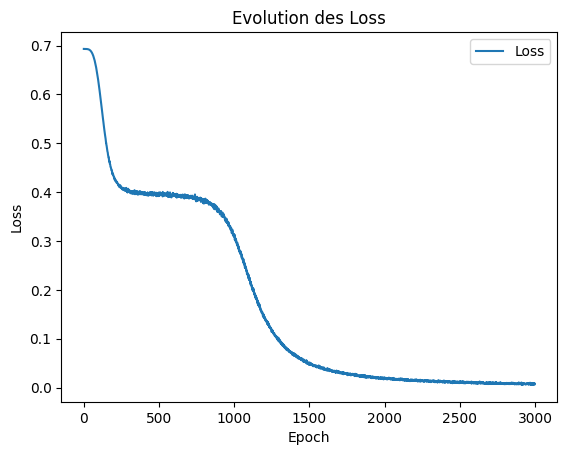

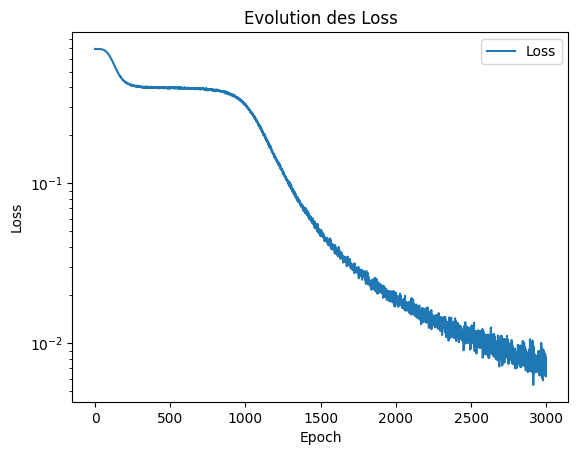

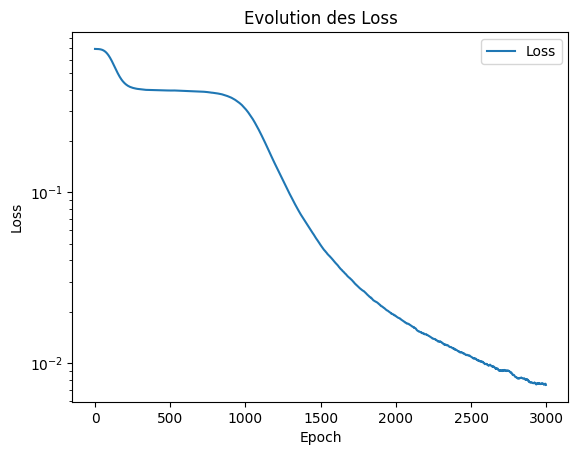

In [83]:
import matplotlib.pyplot as plt
def plot_loss(loss_list):
    plt.plot(loss_list, label='Loss')
    plt.title('Evolution des Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_loss_log(loss_list):
    plt.semilogy(loss_list, label='Loss')
    plt.title('Evolution des Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def running_mean(list,
                 half_window: int # Number of elements that the function will consider 
                                  # ahead and behind the pos X to calculate running mean at X.
                 ):

    running_means = []

    for i in range(0,len(list)):

        left_bound = max(0,i-half_window)
        right_bound = min(len(list)-1, i + half_window)
        sublist = list[left_bound:right_bound+1]
        running_means.append(sum(sublist)/len(sublist))

    return running_means

plot_loss(losses)
plot_loss_log(losses)
plot_loss_log(running_mean(losses, 30))

## Looking for embeddings

In [84]:
model_save_path = "TestComplEx"
loc_path = %pwd
torch.save(model.state_dict(), model_save_path)
print(f'Model saved at {loc_path}/{model_save_path}')

Model saved at /home/elliot/Desktop/StageM2/ESL2024/code/TestComplEx


In [85]:
model.to('cpu')
torch.set_grad_enabled(False)

# Is model coherent ?
iric_first_line = iric.iloc[0].tolist()
map_tail = entity_to_mapping[iric_first_line[0]]
map_head = entity_to_mapping[iric_first_line[2]]
map_rel = relation_to_mapping[iric_first_line[1]]

print("Good score should appear here :")
print(model(torch.tensor(map_tail),torch.tensor(map_rel),torch.tensor(map_head)))

print("Bad scores should appear here :")
print(model(torch.tensor(3307),torch.tensor(0),torch.tensor(4788)))
print(model(torch.tensor(6207),torch.tensor(0),torch.tensor(4378)))

Good score should appear here :
tensor(5.1812)
Bad scores should appear here :
tensor(-4.9341)
tensor(-2.4388)


Attributs pour accéder aux embeddings :

        head_re = self.node_emb(head_index)
        head_im = self.node_emb_im(head_index)
        rel_re = self.rel_emb(rel_type)
        rel_im = self.rel_emb_im(rel_type)
        tail_re = self.node_emb(tail_index)
        tail_im = self.node_emb_im(tail_index)

In [88]:
entities_mapping_to_embedding = {}
relation_mapping_to_embedding = {}

for entity in entity_set:
    entity_id = entity_to_mapping[entity]

    real_part = model.node_emb(torch.tensor(entity_id))
    im_part = model.node_emb_im(torch.tensor(entity_id))

    embedding = torch.cat((real_part, im_part))

    entities_mapping_to_embedding[entity_id] = embedding

for relation in relation_set:
    relation_id = relation_to_mapping[relation]

    real_part = model.rel_emb(torch.tensor(relation_id))
    im_part = model.rel_emb_im(torch.tensor(relation_id))

    embedding = torch.cat((real_part, im_part))

    relation_mapping_to_embedding[relation_id] = embedding


tensor([-3.5229,  2.5405, -3.7383, -4.4250,  2.4816, -2.6202,  2.4349, -3.8420,
         2.5240,  2.4548, -1.3162, -2.4610,  1.0177,  0.3786,  2.4772,  2.3903,
        -2.5410, -0.8160,  2.4756,  2.4941])


In [98]:
# Making the reverse dicts :

entities_embedding_to_mapping ={v: k for k, v in entities_mapping_to_embedding.items()}
relation_embedding_to_mapping = {v: k for k, v in relation_mapping_to_embedding.items()}

# Quick check :
def get_key_value_pair(input_dict, i = 0):
    key = list(input_dict.keys())[i]
    value = input_dict[key]
    return key, value
K = get_key_value_pair(entities_mapping_to_embedding)[0]
V = get_key_value_pair(entities_mapping_to_embedding)[1]

print(f"First key-value pear in entities_mapping_to_embedding :\nKey={K}\nValue={V}")
print(f"And the pair in the symmetric dictentities_embedding_to_mapping :\nKey={V}\nValue={entities_embedding_to_mapping[V]} ")

First key-value pear in entities_mapping_to_embedding :
Key=0
Value=tensor([-1.1559,  0.5924,  0.3884,  1.1206, -0.0205, -0.2717,  0.2994, -0.1845,
        -0.5760,  0.3050,  0.2133,  0.5321, -0.1090,  0.4682,  0.6705, -0.8831,
        -0.6197,  0.4347, -0.0073, -0.1576])
And the pair in the symmetric dictentities_embedding_to_mapping :
Key=tensor([-1.1559,  0.5924,  0.3884,  1.1206, -0.0205, -0.2717,  0.2994, -0.1845,
        -0.5760,  0.3050,  0.2133,  0.5321, -0.1090,  0.4682,  0.6705, -0.8831,
        -0.6197,  0.4347, -0.0073, -0.1576])
Value=0 


# Preparing a dataset to investigate modified loss

## Making negative triples

On va créer n triplets négatifs par triplet positif.
Pour créer un triplet négatif à partir d'un triplet positif, on remplace la tête de ce dernier par une entité aléatoire.
Il y a une chance de créer des faux négatifs, mais comme chaque entité apparait moins d'une fois sur 1000 dans le jeu de données, cette probabilité reste faible.

In [ ]:
# Nombre d'apparition de chaque entité dans iric :
# mapped_iric.hist(column="subject", bins = len(list(entity_set)))

In [ ]:
# Adding negative triples to our dataset.
# This is a naive implementation, it could be accelerated.

import numpy as np
from tqdm import tqdm
import random

def generate_negative_triples(df, number_of_false_per_true, falsify_relation = False):

    negative_triples = []

    possible_heads = list(set(list(df.iloc[:,0])))
    possible_relations = list(set(list(df.iloc[:,1])))
    possible_tails = list(set(list(df.iloc[:,2])))

    for index, row in tqdm(df.iterrows(), total=len(df), desc="Generating Negative Triples"):
        for i in range(number_of_false_per_true):

            if falsify_relation :
                r = np.random.randint(2) 
            else :
                r = np.random.randint(3)

            if r == 0:
                random_head = random.choice(possible_heads)
                negative_triples.append([random_head, row[1], row[2]])

            elif r == 1:
                random_tail = random.choice(possible_tails)
                negative_triples.append([row[0], row[1], random_tail])

            elif r == 2:
                random_relation = random.choice(possible_relations)
                negative_triples.append([row[0], random_relation, row[2]])
                
    negative_triples_df = pd.DataFrame(negative_triples, columns=df.columns)
    return pd.DataFrame(negative_triples_df)

negatives_from_iric = generate_negative_triples(mapped_iric, n_negative_triplets_per_positive)

display(mapped_iric)
display(negatives_from_iric)

Generating Negative Triples:   0%|          | 0/9999 [00:00<?, ?it/s]/tmp/ipykernel_62340/1758883856.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  negative_triples.append([random_head, row[1], row[2]])
/tmp/ipykernel_62340/1758883856.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  negative_triples.append([row[0], random_relation, row[2]])
/tmp/ipykernel_62340/1758883856.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


Generating Negative Triples: 100%|██████████| 9999/9999 [00:02<00:00, 4517.64it/s]


,subject,predicate,object
0,1653,0,7050
1,1653,0,7591
2,908,0,1245
3,3722,0,2126
4,7968,0,3568
...,...,...,...
9994,2253,0,8214
9995,2253,0,5731
9996,3992,0,875
9997,5797,0,3437


,subject,predicate,object
0,8290,0,7050
1,1653,0,7050
2,1653,0,7050
3,1653,0,953
4,1653,0,1696
...,...,...,...
49990,3133,0,5865
49991,954,0,4001
49992,2251,0,4001
49993,3133,0,1133


In [ ]:
# Adding lables to our datas.
# 1 : the link exists ; 0 : the link do not exists.

labelled_mapped_iric = mapped_iric.copy()
labelled_mapped_iric['label']=1
labelled_negatives_from_iric = negatives_from_iric.copy()
labelled_negatives_from_iric['label']=0
mapped_iric_with_negatives = pd.concat([labelled_mapped_iric, labelled_negatives_from_iric])
display(mapped_iric_with_negatives)

,subject,predicate,object,label
0,1653,0,7050,1
1,1653,0,7591,1
2,908,0,1245,1
3,3722,0,2126,1
4,7968,0,3568,1
...,...,...,...,...
49990,3133,0,5865,0
49991,954,0,4001,0
49992,2251,0,4001,0
49993,3133,0,1133,0


In [ ]:
shuffled_mapped_iric_with_negatives = mapped_iric_with_negatives.sample(frac=1).reset_index(drop=True)
display(shuffled_mapped_iric_with_negatives)

,subject,predicate,object,label
0,5631,0,3896,1
1,4573,0,7085,0
2,4258,0,4109,0
3,426,0,3200,0
4,4518,0,8729,0
...,...,...,...,...
59989,7300,0,3059,0
59990,4454,0,1132,1
59991,2236,0,7469,0
59992,7416,0,3617,0


## From mapping to embedding

In [ ]:
emb

In [ ]:
display(shuffled_mapped_iric_with_negatives)

tensorized_triples = shuffled_mapped_iric_with_negatives.copy()
tensorized_triples['object'] = tensorized_triples['object'].apply(lambda x: entities_mapping_to_embedding[x])
tensorized_triples['subject'] = tensorized_triples['subject'].apply(lambda x: entities_mapping_to_embedding[x])
tensorized_triples['predicate'] = tensorized_triples['predicate'].apply(lambda x: relation_mapping_to_embedding[x])
display(tensorized_triples)

,subject,predicate,object,label
0,5631,0,3896,1
1,4573,0,7085,0
2,4258,0,4109,0
3,426,0,3200,0
4,4518,0,8729,0
...,...,...,...,...
59989,7300,0,3059,0
59990,4454,0,1132,1
59991,2236,0,7469,0
59992,7416,0,3617,0


,subject,predicate,object,label
0,"[tensor(0.0401), tensor(-0.6726), tensor(0.411...","[tensor(2.4868), tensor(2.4187), tensor(-3.934...","[tensor(-0.6849), tensor(-0.8253), tensor(1.55...",1
1,"[tensor(0.0805), tensor(0.0231), tensor(0.4883...","[tensor(2.4868), tensor(2.4187), tensor(-3.934...","[tensor(0.3567), tensor(0.4789), tensor(1.1932...",0
2,"[tensor(0.1487), tensor(-0.5875), tensor(0.525...","[tensor(2.4868), tensor(2.4187), tensor(-3.934...","[tensor(-0.4721), tensor(-0.7798), tensor(1.35...",0
3,"[tensor(0.3060), tensor(-0.1338), tensor(0.368...","[tensor(2.4868), tensor(2.4187), tensor(-3.934...","[tensor(-0.4311), tensor(0.3878), tensor(0.286...",0
4,"[tensor(0.0038), tensor(-0.6632), tensor(1.026...","[tensor(2.4868), tensor(2.4187), tensor(-3.934...","[tensor(-0.8098), tensor(-0.1026), tensor(-0.2...",0
...,...,...,...,...
59989,"[tensor(0.0637), tensor(0.9256), tensor(0.1379...","[tensor(2.4868), tensor(2.4187), tensor(-3.934...","[tensor(0.6698), tensor(-0.7704), tensor(0.594...",0
59990,"[tensor(0.3192), tensor(0.4323), tensor(0.9853...","[tensor(2.4868), tensor(2.4187), tensor(-3.934...","[tensor(0.5733), tensor(-0.7344), tensor(0.318...",1
59991,"[tensor(0.1088), tensor(0.2406), tensor(0.5342...","[tensor(2.4868), tensor(2.4187), tensor(-3.934...","[tensor(0.2965), tensor(0.7165), tensor(1.4269...",0
59992,"[tensor(0.5239), tensor(-0.2865), tensor(0.977...","[tensor(2.4868), tensor(2.4187), tensor(-3.934...","[tensor(-0.3941), tensor(-0.5301), tensor(0.49...",0


## Normalizing and merging triples

In [ ]:
def normalize_tensor(x):
    try :
        return normalize(torch.tensor(x), dim=-1,eps=0.000001).clone().detach().requires_grad_(False)
    except :
        raise ValueError(f"Could not normalize this object : \n, {x}")

normalized_tensorized_triples = tensorized_triples.copy()

columns = tensorized_triples.columns[0:3]
print(columns)

tqdm.pandas(desc='Normalizing entities and relations')
for column in columns:
    normalized_tensorized_triples[column]=tensorized_triples[column].progress_apply(normalize_tensor)
    # print(tensorized_triples.iloc[:i])

display(normalized_tensorized_triples)

Index(['subject', 'predicate', 'object'], dtype='object')


Normalizing entities and relations:   0%|          | 0/59994 [00:00<?, ?it/s]/tmp/ipykernel_62340/1031366057.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return normalize(torch.tensor(x), dim=-1,eps=0.000001).clone().detach().requires_grad_(False)
Normalizing entities and relations: 100%|██████████| 59994/59994 [00:03<00:00, 17580.11it/s]


,subject,predicate,object,label
0,"[tensor(0.0172), tensor(-0.2877), tensor(0.176...","[tensor(0.2107), tensor(0.2049), tensor(-0.333...","[tensor(-0.1861), tensor(-0.2243), tensor(0.42...",1
1,"[tensor(0.0661), tensor(0.0189), tensor(0.4004...","[tensor(0.2107), tensor(0.2049), tensor(-0.333...","[tensor(0.1628), tensor(0.2186), tensor(0.5446...",0
2,"[tensor(0.0553), tensor(-0.2185), tensor(0.195...","[tensor(0.2107), tensor(0.2049), tensor(-0.333...","[tensor(-0.1354), tensor(-0.2236), tensor(0.38...",0
3,"[tensor(0.1448), tensor(-0.0633), tensor(0.174...","[tensor(0.2107), tensor(0.2049), tensor(-0.333...","[tensor(-0.1640), tensor(0.1476), tensor(0.109...",0
4,"[tensor(0.0015), tensor(-0.2651), tensor(0.410...","[tensor(0.2107), tensor(0.2049), tensor(-0.333...","[tensor(-0.2849), tensor(-0.0361), tensor(-0.0...",0
...,...,...,...,...
59989,"[tensor(0.0205), tensor(0.2978), tensor(0.0444...","[tensor(0.2107), tensor(0.2049), tensor(-0.333...","[tensor(0.2354), tensor(-0.2708), tensor(0.209...",0
59990,"[tensor(0.1211), tensor(0.1640), tensor(0.3739...","[tensor(0.2107), tensor(0.2049), tensor(-0.333...","[tensor(0.1602), tensor(-0.2053), tensor(0.089...",1
59991,"[tensor(0.0489), tensor(0.1082), tensor(0.2403...","[tensor(0.2107), tensor(0.2049), tensor(-0.333...","[tensor(0.0877), tensor(0.2120), tensor(0.4221...",0
59992,"[tensor(0.2569), tensor(-0.1404), tensor(0.479...","[tensor(0.2107), tensor(0.2049), tensor(-0.333...","[tensor(-0.1481), tensor(-0.1991), tensor(0.18...",0


In [ ]:
tqdm.pandas(desc='Concataning embedded and normalized subjects, predicates and objects')
dataset = normalized_tensorized_triples.progress_apply(lambda row : pd.Series({'x': torch.cat([row.iloc[0], row.iloc[1], row.iloc[2]]), 'y': row.iloc[3]}), axis=1)
display(dataset)

Concataning embedded and normalized subjects, predicates and objects: 100%|██████████| 59994/59994 [00:23<00:00, 2589.17it/s]


,x,y
0,"[tensor(0.0172), tensor(-0.2877), tensor(0.176...",1
1,"[tensor(0.0661), tensor(0.0189), tensor(0.4004...",0
2,"[tensor(0.0553), tensor(-0.2185), tensor(0.195...",0
3,"[tensor(0.1448), tensor(-0.0633), tensor(0.174...",0
4,"[tensor(0.0015), tensor(-0.2651), tensor(0.410...",0
...,...,...
59989,"[tensor(0.0205), tensor(0.2978), tensor(0.0444...",0
59990,"[tensor(0.1211), tensor(0.1640), tensor(0.3739...",1
59991,"[tensor(0.0489), tensor(0.1082), tensor(0.2403...",0
59992,"[tensor(0.2569), tensor(-0.1404), tensor(0.479...",0


In [ ]:
first_subject = normalized_tensorized_triples['subject'][0]
first_predicate = normalized_tensorized_triples['predicate'][0]
first_object = normalized_tensorized_triples['object'][0]
first_triple = dataset['x'][0]
first_object_in_dataset = first_triple[0:hidden_channels*2]

print(first_object_in_dataset.equal(first_subject))

True


## Split dataset

In [ ]:
import pandas as pd

def split_data(dataset, train_ratio=0.7, test_ratio=0.2, val_ratio=0.1):

    total_samples = len(dataset)
    train_size = int(total_samples * train_ratio)
    test_size = int(total_samples * test_ratio)
    
    train_data = dataset[:train_size]
    test_data = dataset[train_size:train_size+test_size]
    val_data = dataset[train_size+test_size:]
    
    return train_data, test_data, val_data

train_ratio = 0.7
test_ratio = 0.2
val_ratio = 0.1

train, test, val = split_data(dataset, train_ratio, test_ratio, val_ratio)

display(train, val, test)

,x,y
0,"[tensor(0.0172), tensor(-0.2877), tensor(0.176...",1
1,"[tensor(0.0661), tensor(0.0189), tensor(0.4004...",0
2,"[tensor(0.0553), tensor(-0.2185), tensor(0.195...",0
3,"[tensor(0.1448), tensor(-0.0633), tensor(0.174...",0
4,"[tensor(0.0015), tensor(-0.2651), tensor(0.410...",0
...,...,...
41990,"[tensor(0.2133), tensor(0.1413), tensor(0.5001...",1
41991,"[tensor(-0.0951), tensor(0.1260), tensor(0.474...",1
41992,"[tensor(0.2003), tensor(0.2742), tensor(0.3669...",0
41993,"[tensor(0.0351), tensor(-0.0310), tensor(0.417...",0


,x,y
53993,"[tensor(-0.1263), tensor(-0.3321), tensor(0.17...",0
53994,"[tensor(-0.3036), tensor(-0.2250), tensor(0.39...",0
53995,"[tensor(-0.1362), tensor(-0.2394), tensor(0.16...",0
53996,"[tensor(0.0801), tensor(-0.1593), tensor(0.177...",0
53997,"[tensor(0.0602), tensor(-0.0266), tensor(0.404...",0
...,...,...
59989,"[tensor(0.0205), tensor(0.2978), tensor(0.0444...",0
59990,"[tensor(0.1211), tensor(0.1640), tensor(0.3739...",1
59991,"[tensor(0.0489), tensor(0.1082), tensor(0.2403...",0
59992,"[tensor(0.2569), tensor(-0.1404), tensor(0.479...",0


,x,y
41995,"[tensor(0.0052), tensor(-0.0719), tensor(0.437...",0
41996,"[tensor(0.0546), tensor(0.2436), tensor(0.4853...",0
41997,"[tensor(0.2155), tensor(-0.1640), tensor(0.006...",0
41998,"[tensor(-0.1998), tensor(-0.0400), tensor(0.46...",0
41999,"[tensor(0.1547), tensor(-0.2399), tensor(0.341...",1
...,...,...
53988,"[tensor(-0.3142), tensor(0.2332), tensor(0.003...",1
53989,"[tensor(0.1731), tensor(0.1150), tensor(0.2386...",1
53990,"[tensor(-0.1409), tensor(0.0029), tensor(0.494...",0
53991,"[tensor(-0.0315), tensor(0.1639), tensor(-0.05...",1


# Testing loss difference

## Defining models

Here we define 3 models :
- untrained(), that we never train.
- classic(), that we train with a standard loss
- special(), that we train with a loss including Lin's similarity


In [ ]:
print(dataset['x'][0].size()[0] == 6*hidden_channels)

True


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Créer le MLP
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Paramètres du modèle
input_size = 6 * hidden_channels  
hidden_size = 128  
output_size = 1     
# Créer des instances du modèle, de la loss et de l'optimiseur
model = MLP(input_size, hidden_size, output_size)



## Defining losses

In [ ]:
nxo = from_file(url)
nxo.freeze()

def lin_similarity(term1:str, term2:str, ontologies:list, error_return = -1):
  '''
  Returns the highier lin similarity of two entities of a list of given ontologies.
  /!\ If calculation is impossible (for example if one of the entities is in none of the ontologies), return 0.

  Parameters :
  - term1 (str): ID of the first entity as a string (example : "GO:0042552")
  - term2 (str): ID of the second entity as a string (example : "GO:0042552")
  - ontology (list of nxontology.ontology.NXOntology objects) : A list of ontologies loaded with nxontology.
  - error_return : The output of the function if lin similarity cannot be calculated. Default -1.

  Returns :
  - linsim (float): The Lin similarity of the two entities in the ontology.
                    It is a a number in [0;1].
                    linsim(A,B) close of 0 means A and B are distant in the ontology ;
                    lisnsim(A,B) close of 1 means A and B are close entities in the ontology.
  '''
  similarities = []
  for ontology in ontologies:
    try :
      similarities.append(ontology.similarity(term1, term2).lin)
    except :
      similarities.append(error_return)


# Définir la loss personnalisée
def custom_loss(output, target):
    for 

SyntaxError: invalid syntax (4272830280.py, line 31)

## Training

In [ ]:
criterion = custom_loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convertir les données en tenseurs PyTorch
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size)
test_loader = DataLoader(test, batch_size=batch_size)


KeyError: 11714

## Test

KeyError: 0